In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("C:/Users/BiDAlab/TFG_Alfonso/Pruebas/Modelo2/MIMIC/CSV/V5/archivo_combiando_v5.csv")
df = df.dropna()
# Contar los casos de sepsis (1) y no sepsis (0)
conteo_sepsis = df['sepsis'].value_counts()

# Mostrar los resultados
print("Casos de No Sepsis (0):", conteo_sepsis.get(0, 0))
print("Casos de Sepsis (1):", conteo_sepsis.get(1, 0))

# Mostrar las primeras filas para verificar los datos
print(df.head())

# Separar características (X) y la variable objetivo (y)
# Asegúrate de que 'objetivo' es el nombre de la columna que quieres predecir
X = df.drop(columns=['sepsis'])  # Reemplaza 'objetivo' por el nombre correcto
y = df['sepsis']

# Eliminar patientunitstayid de las características ya que no es relevante y mejoraba el modelo
X = X.drop(columns=['subject_id'], errors='ignore')

from sklearn.feature_selection import SelectKBest, f_classif

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# # Escalar los datos (importante para SVM)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Casos de No Sepsis (0): 6575
Casos de Sepsis (1): 6569
   subject_id  gender  anchor_age  sis_desviacion  dias_desviacion  \
0    10002013       0          53       16.689746         8.576824   
1    10002155       0          80        9.555103         7.056912   
2    10002428       0          80       16.925170        12.605705   
3    10002760       1          56        9.953648         4.998814   
4    10003400       0          72       10.814669         9.766610   

   mean_desviacion   sis_media  dias_media  mean_media  sis_mediana  ...  \
0        13.514515  110.619048   61.476190   76.700000        116.0  ...   
1         8.105554  113.400000   57.400000   80.200000        115.0  ...   
2        15.075749  110.987220   59.006390   79.524845        109.0  ...   
3         5.984499  108.434783   57.521739   74.217391        107.0  ...   
4         9.163913  102.727749   64.884817   78.518325        102.0  ...   

   mean_mediana  dias_tendencia  sis_tendencia  mean_tendencia  sep

In [4]:
# Mostrar las filas que contienen valores NaN
filas_con_nan = df[df.isnull().any(axis=1)]
print(filas_con_nan)


Empty DataFrame
Columns: [subject_id, gender, anchor_age, sis_desviacion, dias_desviacion, mean_desviacion, sis_media, dias_media, mean_media, sis_mediana, dias_mediana, mean_mediana, dias_tendencia, sis_tendencia, mean_tendencia, sepsis, total_warnings_temperatura, total_warnings_oxigeno, oxigeno_min_24h, oxigeno_max_24h, tendencia_SpO2]
Index: []

[0 rows x 21 columns]


In [5]:
# Crear el modelo SVM
svm_model = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)

# Entrenar el modelo
svm_model.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

Accuracy: 0.698744769874477
Confusion Matrix:
 [[1034  275]
 [ 517  803]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.79      0.72      1309
           1       0.74      0.61      0.67      1320

    accuracy                           0.70      2629
   macro avg       0.71      0.70      0.70      2629
weighted avg       0.71      0.70      0.70      2629



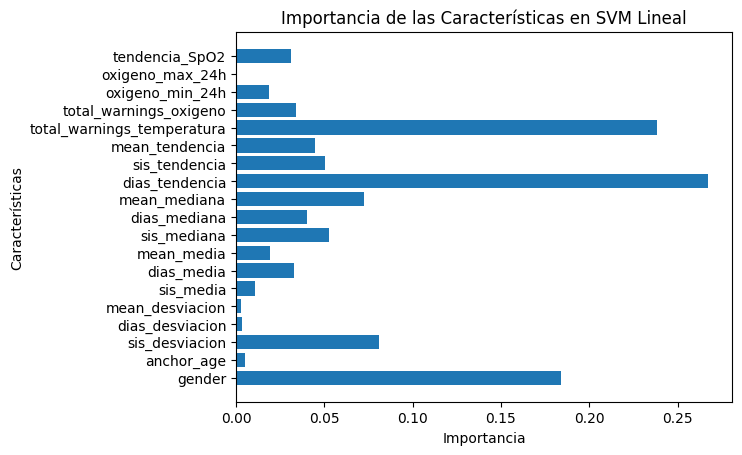

In [6]:
# Realizar predicciones
y_pred = svm_model.predict(X_test)

# Evaluar el rendimiento
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Si es un SVM lineal, podemos obtener los coeficientes
if hasattr(svm_model, 'coef_'):
    coef = svm_model.coef_.flatten()  # Extraer los coeficientes
    importance = np.abs(coef)  # Tomar el valor absoluto para la importancia

    # Graficar las características con sus nombres
    plt.barh(X_train.columns, importance)  # Asegúrate de que X_train tenga nombres de columnas
    plt.xlabel('Importancia')
    plt.ylabel('Características')
    plt.title('Importancia de las Características en SVM Lineal')
    plt.show()


In [ ]:
# Definir el modelo SVM
svm_model = SVC()

# Definir la rejilla de parámetros para optimización
param_grid = {
    'C': [0.1, 1, 10, 100],         # Regularización
    'kernel': ['linear', 'rbf'],    # Tipos de kernel
    'gamma': ['scale', 'auto', 0.01, 0.001],  # Solo para kernel 'rbf'
}

# Optimización de hiperparámetros usando GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 3)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)


# Evaluar el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)

# Métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


In [7]:
from sklearn.pipeline import make_pipeline
# Crear el pipeline: primero normaliza los datos, luego aplica SVM
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale'))

# Entrenar el modelo con los datos sin normalizar
svm_pipeline.fit(X_train, y_train)

# Realizar predicciones
y_pred = svm_pipeline.predict(X_test)

# Evaluar el rendimiento
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7219475085583872
Confusion Matrix:
 [[1056  253]
 [ 478  842]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.81      0.74      1309
           1       0.77      0.64      0.70      1320

    accuracy                           0.72      2629
   macro avg       0.73      0.72      0.72      2629
weighted avg       0.73      0.72      0.72      2629



In [8]:
# 1. Crear el pipeline con normalización y SVM
pipeline = make_pipeline(StandardScaler(), SVC())

# 2. Definir el grid de parámetros que queremos optimizar
param_grid = {
    'svc__C': [0.1, 1, 10, 100],         # Penalización por errores
    'svc__gamma': ['scale', 0.01, 0.1, 1],  # Parámetro de control de la curvatura (solo para kernels no lineales)
    'svc__kernel': ['linear', 'rbf']  # Tipo de kernel: lineal, radial o polinomial
}

# 3. Configurar GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 3)

# 4. Entrenar el modelo con GridSearch
grid_search.fit(X_train, y_train)

# 5. Ver los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# 6. Evaluar el modelo en los datos de prueba
y_pred = grid_search.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros encontrados: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy: 0.7341194370483073
Confusion Matrix:
 [[1023  286]
 [ 413  907]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.75      1309
           1       0.76      0.69      0.72      1320

    accuracy                           0.73      2629
   macro avg       0.74      0.73      0.73      2629
weighted avg       0.74      0.73      0.73      2629

